In [1]:
import os
import cv2
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


np.random.seed(1000)
# ignore information messgaes from tensorflow, but we will receieve error messages
os.environ['TFF_CPP_MIN_LOG_LEVEL'] = '2'

%matplotlib inline

In [2]:
DATA_DIR = 'E:/Skin cancer ISIC The International Skin Imaging Collaboration'
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'train')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'test')


In [3]:
IMG_SIZE = 32
CATEGORIES = []

for i in os.listdir(TRAIN_DATA_DIR):
    CATEGORIES.append(i)
    
print(CATEGORIES)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


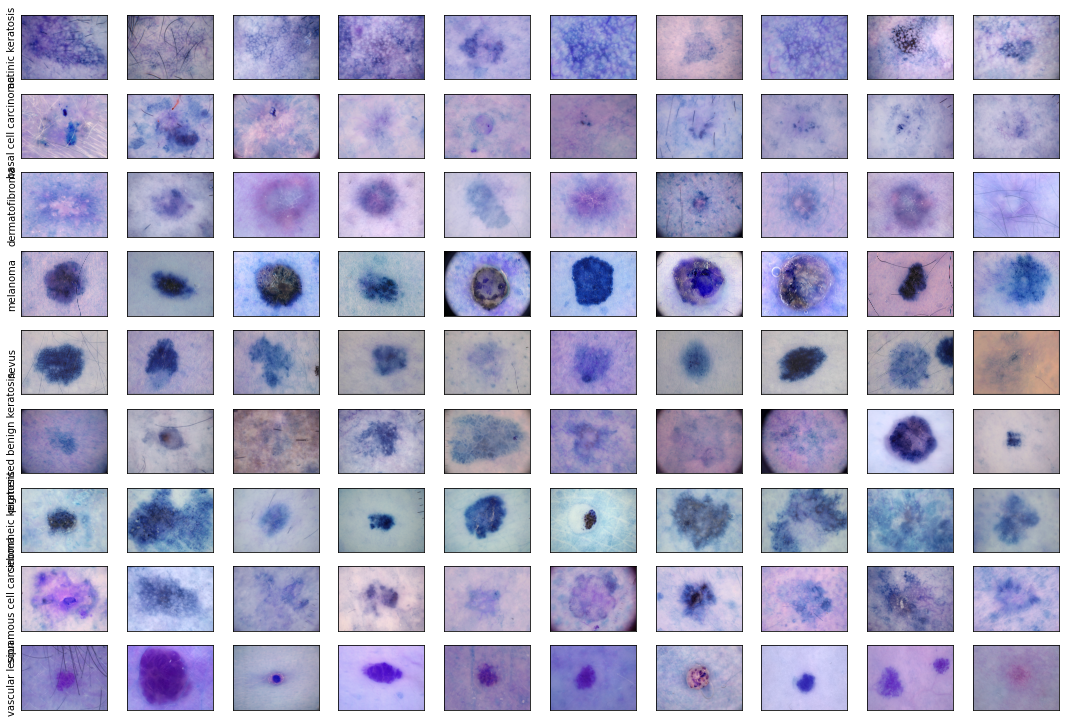

In [4]:
plt.figure(figsize=(15,10))
i=0
for c in CATEGORIES:  
    path = os.path.join(TRAIN_DATA_DIR,c)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.subplot(9,10,i+1)
        plt.imshow(img_array)
        if i%10 == 0:
            plt.ylabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        if i%10 == 0:
            break

plt.tight_layout()        
plt.show() 

In [5]:
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c) 
    class_num = CATEGORIES.index(c) # 0
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize the image
            training_data.append([img_resized, class_num]) # [ [img, 0], [], [], [], ...., []]
        except WException as e:
            pass
        
print(len(training_data))

100%|██████████| 139/139 [00:01<00:00, 85.17it/s]

2239


In [6]:
test_data = []

for c in CATEGORIES:
    path = os.path.join(TEST_DATA_DIR, c) 
    class_num = CATEGORIES.index(c) 
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
            test_data.append([img_resized, class_num])
        except WException as e:
            pass
        
print(len(test_data))

100%|██████████| 3/3 [00:00<00:00, 45.56it/s]

118


In [7]:
import random
random.shuffle(training_data)
random.shuffle(test_data)

In [8]:
X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)
    
X_train = np.array(X_train).astype('float32').reshape(-1,32,32,3)
Y_train = np.array(Y_train).astype('float32')

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (2239, 32, 32, 3) Y_train= (2239,)


In [9]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")

X_test= (118, 32, 32, 3) Y_test= (118,)


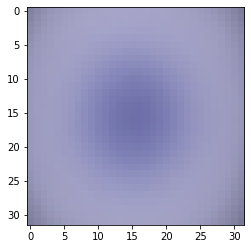

In [10]:
mean_img = np.mean(X_train, axis=0)
plt.imshow(mean_img.astype('uint8'))

In [11]:
X_train_norm, X_test_norm = X_train-mean_img, X_test-mean_img

In [29]:
from tensorflow.keras import layers
from keras.layers import Input,Dense,Reshape,Flatten, MaxPool2D 
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU  
from keras.layers import Conv2D
from keras.models import Sequential,Model  
from tensorflow.keras.optimizers import Adam
import random 
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='tanh', padding = 'same', input_shape=(32,32,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    layers.BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3, 3), activation='tanh', padding = 'same', input_shape=(32,32,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    layers.BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3, 3), activation='tanh', padding = 'same', input_shape=(32,32,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    layers.BatchNormalization(),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(32,32,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    layers.BatchNormalization(),
    Flatten(),
   Dense(units= 9, activation='softmax')
])

In [30]:
model.compile(optimizer=tf.keras.optimizers.Nadam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [31]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 64)         

In [32]:
from keras.callbacks import EarlyStopping
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    
  def on_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['accuracy'])
    
# Early stopping to stop the training if loss start to increase. It also avoids overfitting.
es = EarlyStopping(patience=3,monitor="val_loss")

In [37]:
from keras.callbacks import EarlyStopping
#set early stopping monitor so the model stops training when it won't improve anymore
early_stopping_monitor = EarlyStopping(patience=3)

h = model.fit(x=X_train, y= Y_train, epochs=5, validation_split=0.2, callbacks=[early_stopping_monitor])

Epoch 1/5
56/56 [==============================] - 1s 12ms/step - loss: 0.2542 - accuracy: 0.9280 - val_loss: 1.9095 - val_accuracy: 0.3839
Epoch 2/5
56/56 [==============================] - 1s 12ms/step - loss: 0.2388 - accuracy: 0.9341 - val_loss: 1.8718 - val_accuracy: 0.3973
Epoch 3/5
56/56 [==============================] - 1s 12ms/step - loss: 0.2279 - accuracy: 0.9330 - val_loss: 1.9087 - val_accuracy: 0.4018
Epoch 4/5
56/56 [==============================] - 1s 12ms/step - loss: 0.2206 - accuracy: 0.9347 - val_loss: 1.8793 - val_accuracy: 0.3884
Epoch 5/5
56/56 [==============================] - 1s 12ms/step - loss: 0.2133 - accuracy: 0.9330 - val_loss: 1.9150 - val_accuracy: 0.4018


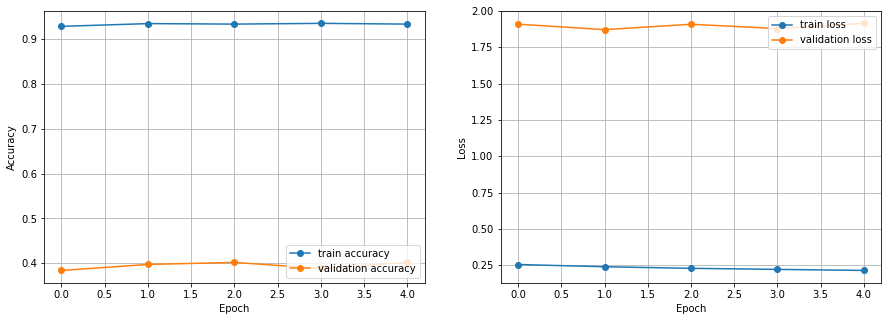

In [38]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='train accuracy')
plt.plot(h.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='train loss')
plt.plot(h.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [39]:
test_loss, test_acc = model.evaluate(X_test, Y_test)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)

4/4 [==============================] - 0s 4ms/step - loss: 2.4888 - accuracy: 0.3220

Test Accuracy: 0.32203391194343567

Test Loss: 2.4888131618499756


In [40]:
predictions = model.predict(X_test)

In [41]:
for layer in model.layers:
    
    if 'conv' not in layer.name:
        continue    
    filters , bias = layer.get_weights()
    print(layer.name , filters.shape)

conv2d_4 (3, 3, 3, 32)
conv2d_5 (3, 3, 32, 64)
conv2d_6 (3, 3, 64, 64)
conv2d_7 (3, 3, 64, 64)


In [42]:
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

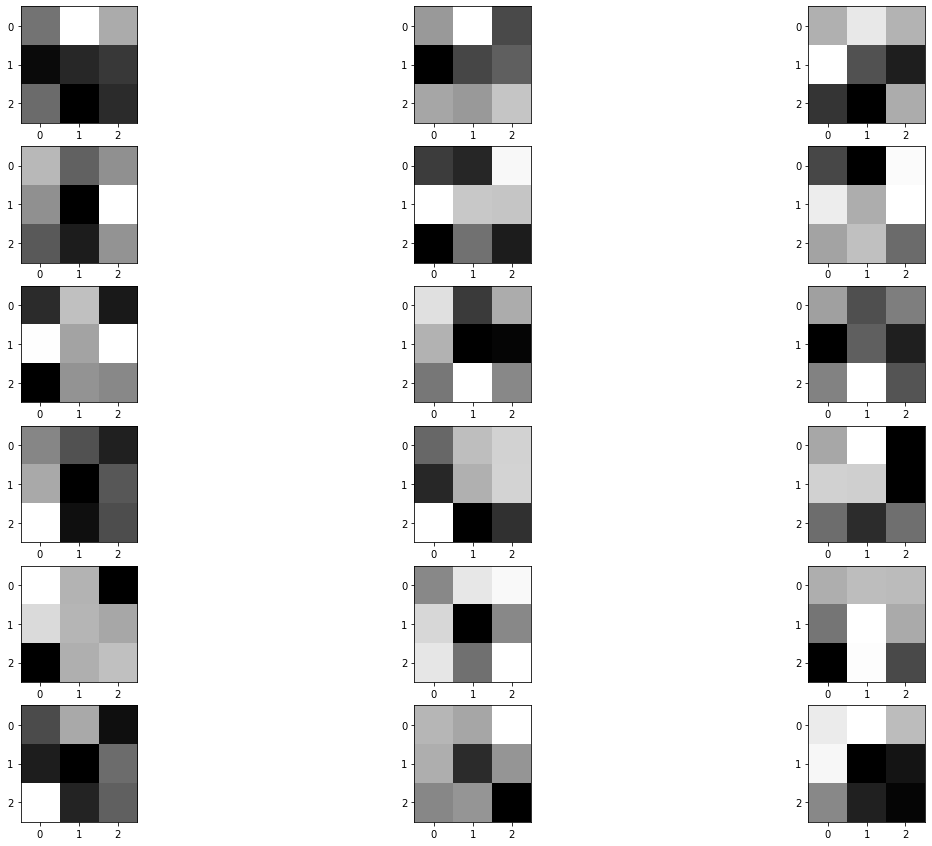

In [43]:
n_filters =6
ix=1
fig = plt.figure(figsize=(20,15))
for i in range(n_filters):
    # get the filters
    f = filters[:,:,:,i]
    for j in range(3):
        # subplot for 6 filters and 3 channels
        plt.subplot(n_filters,3,ix)
        plt.imshow(f[:,:,j] ,cmap='gray')
        ix+=1
#plot the filters 
plt.show()

In [44]:
for i in range(len(model.layers)):
    layer = model.layers[i]
    if 'conv' not in layer.name:
        continue    
    print(i , layer.name , layer.output.shape)

0 conv2d_4 (None, 32, 32, 32)
3 conv2d_5 (None, 16, 16, 64)
6 conv2d_6 (None, 8, 8, 64)
9 conv2d_7 (None, 4, 4, 64)


In [45]:
model = Model(inputs=model.inputs , outputs=model.layers[1].output)

In [46]:
from keras.preprocessing.image import load_img
image = load_img("E:/Skin cancer ISIC The International Skin Imaging Collaboration/Test/dermatofibroma/ISIC_0011677.jpg" , target_size=(32,32))

# convert the image to an array
image = tf.keras.utils.img_to_array(image)
# expand dimensions so that it represents a single 'sample'
image = tf.expand_dims(image, axis=0)

In [47]:
from keras.applications.imagenet_utils import preprocess_input
image = preprocess_input(image)

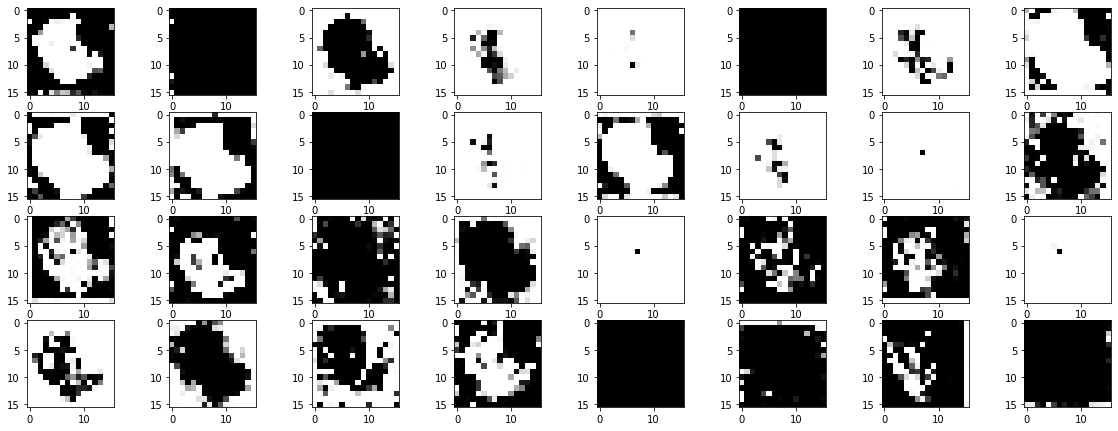

In [48]:
features = model.predict(image)

fig = plt.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):

    plt.subplot(8,8,i)
    plt.imshow(features[0,:,:,i-1] , cmap='gray')
    
plt.show()